# Práctica 4a. Selección de características numéricas.

La selección de carectrísticas es importante ya que permite que el algoritmo de machine learning entrene de una manera más rápida, reduce la complejidad del modelo y facilita su comprensión. Esta técnica se quedará con la información que realmente es importante y desechará el resto.

## Dataset 2.

Este dataset es sobre la calidad del vino rojo.

In [3]:
# Importamos las librerías con las que visualizaremos los datos y usemos las técnicas de extracción
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [4]:
# Cargando el dataset
df = pd.read_csv('winequality-red.csv', sep=',')
df = pd.DataFrame(df)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Método de filtro

Este método se usa normalmente como un paso de preprocesamiento. Las características se seleccionan en función de sus puntajes en varias pruebas estadísticas para su correlación con la variable de resultado. Ya que nuestro dataset es numérico podemos utilizar la correlación de Pearson para determinar la dependencia lineal entre las variables.

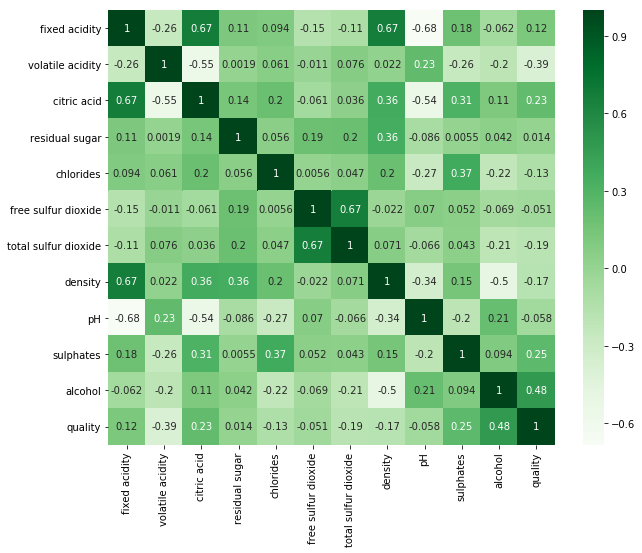

In [10]:
# Graficaremos la matriz de correlación entre las variables para que sea más fácil verlo
plt.figure(figsize=(10,8))
mat_cor = df.corr()
sns.heatmap(mat_cor, annot=True, cmap=plt.cm.Greens)
plt.show()

In [16]:
#Correlación respecto a la variable de salida o target
cor_target = abs(mat_cor["quality"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

quality    1.0
Name: quality, dtype: float64

La variable 'quality' no tiene correlación alta con alguna otra.

### Método de envoltura (Wrapped method)

En los métodos de envoltura, intentamos usar un subconjunto de características y entrenar un modelo con ellas. Según las inferencias que extraemos del modelo anterior, decidimos agregar o eliminar características de su subconjunto. El problema se reduce esencialmente a un problema de búsqueda.

#### Eliminación hacia atrás (Backward elimination)

En la eliminación hacia atrás, comenzamos con todas las características y eliminamos la característica menos significativa en cada iteración que mejora el rendimiento del modelo. Repetimos esto hasta que no se observe ninguna mejora en la eliminación de características.

In [17]:
# Separamos las variables dependientes e independiente
X = df.drop("quality", 1)
y = df["quality"]

In [18]:
# Agregamos columna de 1's a las variables dependientes
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


density                 4.086079e-01
fixed acidity           3.356528e-01
const                   3.001921e-01
residual sugar          2.764960e-01
citric acid             2.149942e-01
free sulfur dioxide     4.474495e-02
pH                      3.100189e-02
chlorides               8.373953e-06
total sulfur dioxide    8.004610e-06
sulphates               2.127228e-15
volatile acidity        9.872361e-19
alcohol                 1.123029e-24
dtype: float64

In [19]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']


Notamos que las características con p<0.05 son las que mejor rendimiento tienen, por lo que las características en  selected_features_BE se quedan y las demás se eliminan.

### Eliminación recursiva de características (Recursive Feature Elimination - RFE)

In [24]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 6, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
[False  True False False  True False False  True  True  True  True]
[3 1 2 4 1 5 6 1 1 1 1]


Características importantes: 'volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol', 'quality'.

Ahora necesitamos encontrar el número óptimo de características para las cuales la precisión es la más alta.

In [30]:
#Número de características
nof_list = np.arange(1,11)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 10
Desempeño con 10 características: 0.317282


In [31]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates',
       'alcohol'],
      dtype='object')


### Métodos integrados (Embedded method)

In [32]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:6
Desempeño mediante la regularización Lasso: 0.344854


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

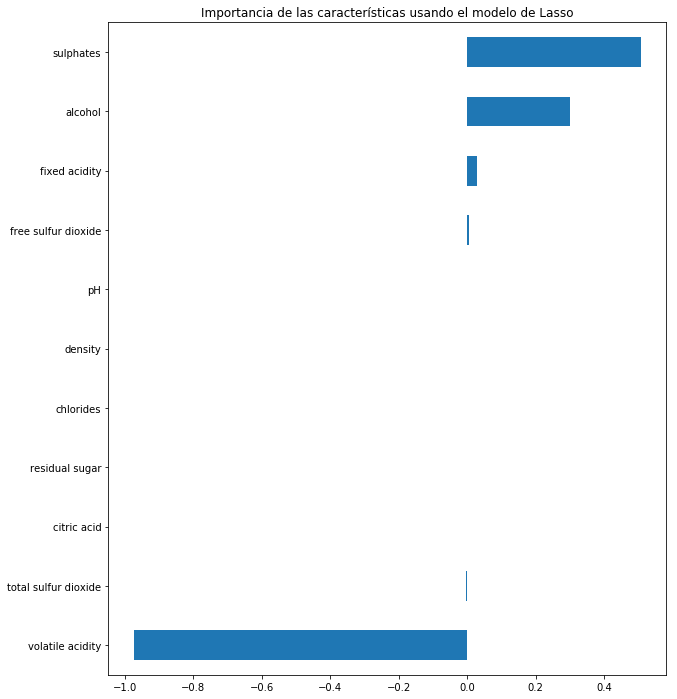

In [36]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0,12.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")

LASSO tomó 5 características 'sulphates', 'alcohol', 'fixed acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'volatile acidity'.